In [1]:
import matplotlib.pyplot as plt
import numpy as np
from okada_wrapper import dc3d0wrapper, dc3dwrapper

**Turkiye Earthquake Attributes** <br>
Magnitude / Strike / Dip / Rake / Centroid depth from USGS Earthquakes. <br>
Surface slip from *<a href='https://www.sciencedirect.com/science/article/pii/S1674451923000290'>Wu et al. (2023)<a/>* <br>
Strike Rupture length from *<a href='https://pubs.geoscienceworld.org/ssa/tsr/article/3/4/289/628908/Rapid-Surface-Rupture-Mapping-from-Satellite-Data'>Reitman et al. (2023)<a/>* <br>

| Mag | Strike | Dip | Rake | Centroid Depth (USGS) | Slip (m) | Strike Rupture |
| :---: | :-----: | :------: | :-----: | :-----: | :-----: | :-----: |
| 7.8 | 228 | 89 | -1 | 10 | 3-7 | 345 |
| 7.4 | 277 | 78 | 4 | 7.4 | 1-5 | 175 |

**Downloaded Sentinel-1 Data features**
| Orbit | Subswath |
| :--------: | :-------: |
| Descending | 1 |

### Initial Parameters

In [2]:
lmda = 30e9                       # 30 GPa is a standar value for continental crust
mu = 30e9                         # 30 GPa is a standar value for continental crust
alpha = (lmda+mu) / (lmda + 2*mu) # Elastic constant used by Okada

### Fault properties

In [10]:
strike,dip,rake = 228,89,-1  # degrees
slip = 5                     # surface slip. unit - m
as_length = 345e3            # Along strike length. unit - m
dd_width = 20e3              # Down dip width. unit - m
cd_depth = 10e3              # centroid depth. unit - m
xs = 0                       # x-coords pf center of fault up-dip projection
ys = 0                       # y-coords pf center of fault up-dip projection

### Calculate centroid coordinates

In [11]:
# Calculate the centroid coords
rc = cd_depth/np.tan(np.radians(dip))  # Radial surface distance from (xs,ys) to centroid
rcx = rc*np.sin(np.radians(strike+90)) # Coordinate shift in x from xs to centroid
rcy = rc*np.cos(np.radians(strike+90)) # Coordinate shift in y from ys to centroid
xc = xs+rcx # x coord pf centroid
yc = ys+rcy # y coord pf centroid
print(f"The fault centroid is at ({xc:.2f}, {yc:.2f}, {cd_depth:.2f})\n")

# Convert. from slip and rake to strike-slip and dip-slip
ss = slip*np.cos(np.radians(rake))
ds = slip*np.sin(np.radians(rake))
print(f'strike-slip: {ss:.2f}m\ndip-slip:   {ds:.2f}m')

# Make a rotation matrix to account for the along x-axis assumption in the okada model
R = np.array([[np.cos(np.radians(strike-90)), -np.sin(np.radians(strike-90))],
              [np.sin(np.radians(strike-90)), np.cos(np.radians(strike-90))]])

The fault centroid is at (-116.80, 129.72, 10000.00)

strike-slip: 5.00m
dip-slip:   -0.09m


### Running the Okada model to generate displacement

In [25]:
nx,ny = (101,101) # number of cellls in the x and y directions
x = np.linspace(-200000, 200000, nx)
y = np.linspace(-200000, 200000, ny)

# Initialize empty arrays to store the output
UX = np.zeros((nx, ny))
UY = np.zeros((nx, ny))
UZ = np.zeros((nx, ny))

for i in range(nx):
    for j in range(ny):
        # Shift and rotate the coordinates into Okada geometry
        P = np.array([[x[i]-xc],
                      [y[j]-yc]]) # Observation point wrt centroid in map coordinates
        Q = R.dot(P)              # observation pont rotated into Okada geometry
        
        # Run the Okada dc3d function on the rotated coordinates
        success, u, grad_u = dc3dwrapper(alpha, 
                                         [Q[0], Q[1], 0],
                                         cd_depth,
                                         dip,
                                         [-as_length/2, as_length/2],
                                         [-dd_width/2, dd_width/2],
                                         [ss, ds, 0.0])
        assert(success==0)
        
        # here u[0] is a strike parallel displacement and u[1] is a strike-nor,a; displacement
        UX[i, j] = u[0]*np.sin(np.radians(strike))-u[1]*np.cos(np.radians(strike)) # x displacement
        UY[i, j] = u[0]*np.cos(np.radians(strike))-u[1]*np.sin(np.radians(strike)) # y displacement
        UZ[i, j] = u[2] # z displacement

In [26]:
# Plotting functions
def create_contours(px,py,pz,pc,ax=None):
    if ax is None:
        ax = plt.gca()
    ax.contourf(px,py,pz,levels=pc)
    ax.contour(px,py,pz,colors='k', levels=pc, linestyles='-', linewidths=0.6)
    return ax
# Axis title label placeholders
title_dict = {0:'X',1:'Y',2:'Z',3:'Total'}

### Plot the modeled displacement for all components

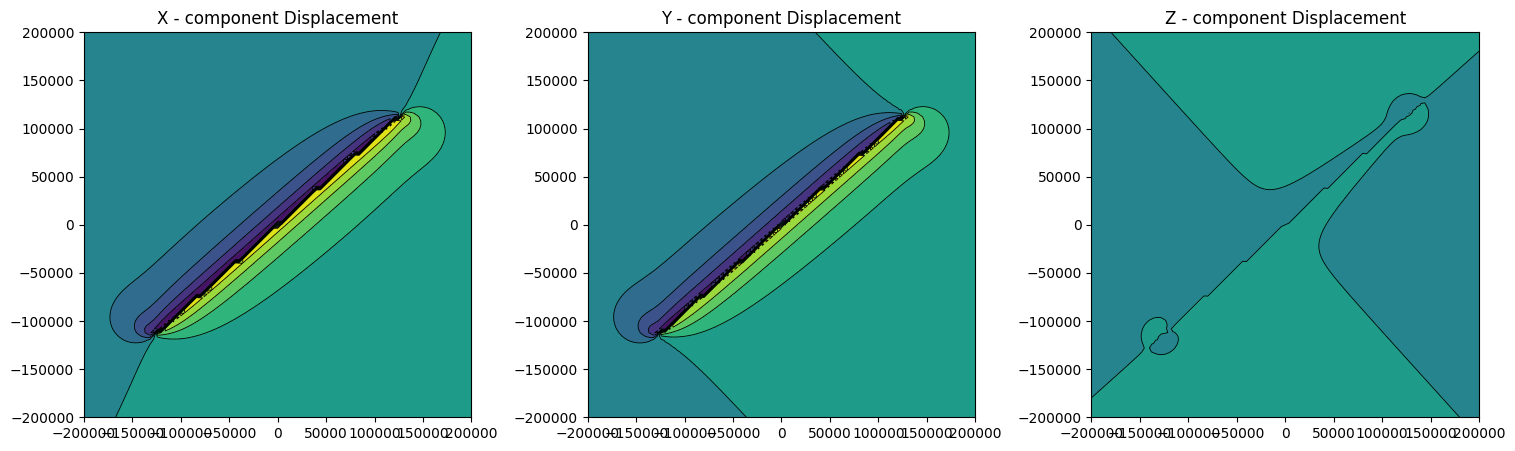

In [27]:
fig, axes = plt.subplots(1,3,figsize=(18,5), gridspec_kw={'wspace':0.3})
levels = np.linspace(-1.9, 1.9, 11) # Color values for contour map

create_contours(x,y,UX.T,levels,axes[0])
create_contours(x,y,UY.T,levels,axes[1])
create_contours(x,y,UZ.T,levels,axes[2])


for idx,ax in enumerate(axes):
    ax.set_title(f"{title_dict[idx]} - component Displacement")

plt.show()
    

### Convert the displacement values into satellite line of sight (LOS)
Incidence angle (theta) values for Sentinel-1 subswaths. <br>
- Subswath 1: 31˚- 37˚
- Subswath 2: 37˚- 42˚
- Subswath 3: 42˚- 46˚

In [28]:
theta = 33   # appropriate for Sentinel-1 subswath 1
phi = -100   # angle from the north for descending track
# phi = -260 # angle from the north for ascending track

# Pointing vector
p_vec = [np.sin(np.radians(phi))*np.sin(np.radians(theta)), 
         -np.cos(np.radians(phi))*np.sin(np.radians(theta)), 
         -np.cos(np.radians(theta))]

print(f"Pointing vector components: px = {p_vec[0]:.2f}, py = {p_vec[1]:.2f}, pz = {p_vec[2]:.2f}")

Pointing vector components: px = -0.54, py = 0.09, pz = -0.84


### Scale each displacement component by its corresponding pointing unit vector component
Regardless of the source model, the North-South(y-component) of deformation contributes very little to the total LOS. Depending on the model, x and z components can also destrutively interfere with each other, giving different patterns

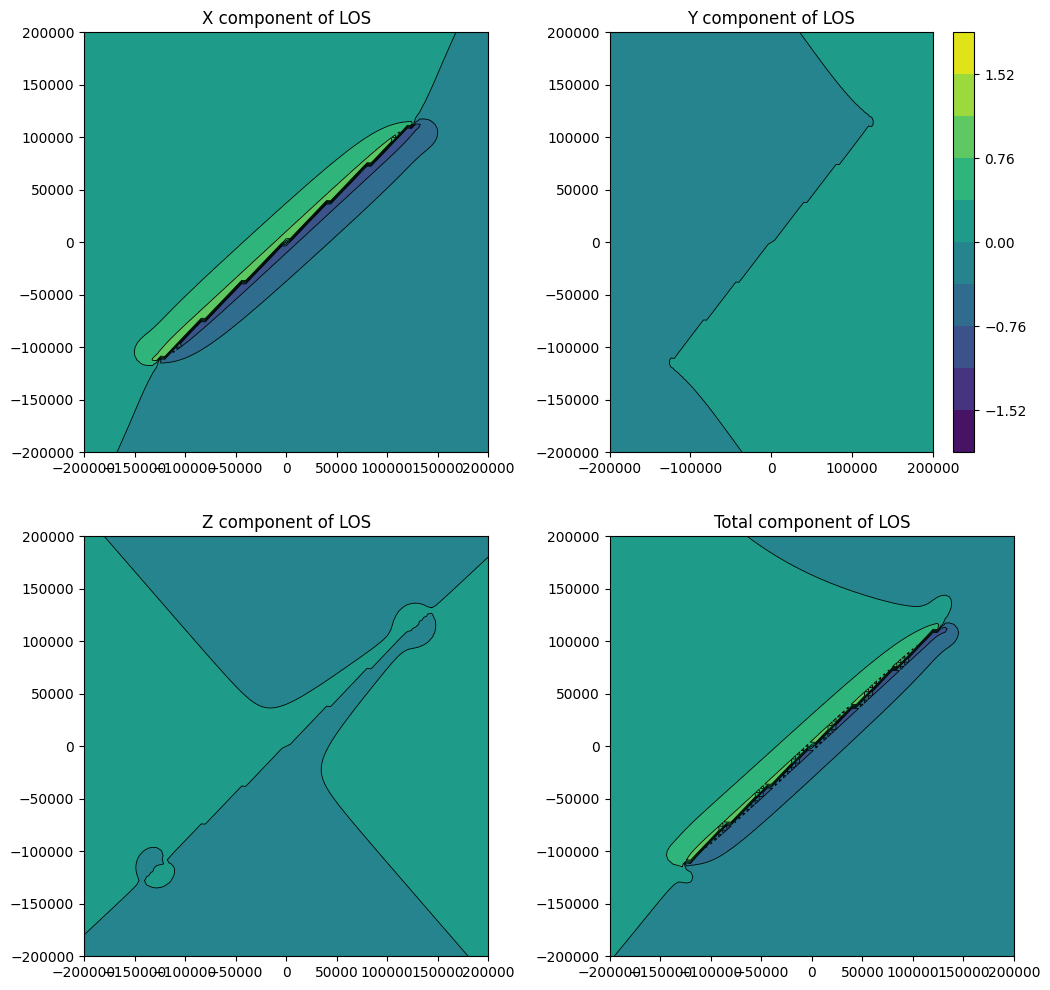

In [29]:
ULOS_X = UX * p_vec[0]
ULOS_Y = UY * p_vec[1]
ULOS_Z = UZ * p_vec[2]

# Total line of sight is the sum of all components
ULOS = ULOS_X + ULOS_Y + ULOS_Z

col = plt.contourf(x,y,ULOS, levels=levels)
plt.close()


fig,axes = plt.subplots(2,2,figsize = (12,12), gridspec_kw={'wspace': 0.3})
axes = axes.flatten()

create_contours(x,y,ULOS_X.T,levels,axes[0])
create_contours(x,y,ULOS_Y.T,levels,axes[1])
create_contours(x,y,ULOS_Z.T,levels,axes[2])
create_contours(x,y,ULOS.T,levels,axes[3])
fig.colorbar(col,ax=axes[1])

for idx,ax in enumerate(axes):
    ax.set_title(f"{title_dict[idx]} component of LOS")
    
plt.show()